In [1]:
import aplpy
import os
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.convolution import convolve_fft, Gaussian2DKernel
import math 
from astropy import units as u
from scipy.interpolate import UnivariateSpline
import scipy.optimize as optimize
from scipy.interpolate import interp1d
import sys
from numpy.random import rand,seed
from pylab import *
from scipy import stats
import lmfit 
from scipy.special import erf
from lmfit import Minimizer, Parameters, fit_report

In [2]:
#LOADING IN DATA FILES
after_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B1_000_clean14_1_pbcor.fits')
before_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B1snap_000.fits')
after_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B1_051_clean14_pbcor.fits')
before_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B1snap_051.fits')
after_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B10_000_clean14_pbcor.fits')
before_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B10snap_000.fits')
after_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B10_066_clean14_pbcor.fits')
before_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B10snap_066.fits')
noise_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B1snap_000_clean14_1_noise_finalfwhm.fits')
noise_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B1snap_051_clean14_noise_finalfwhm.fits')
noise_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B10snap_000_clean14_noise_finalfwhm.fits')
noise_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B10snap_066_clean14_noise_finalfwhm.fits')

In [3]:
#SIMULATED OBSERVATIONAL DATA
def simulated_data_retrieval(sim_self):
    sim_self = sim_self[0].data
    column_density_array_after = sim_self
    flat_column_density_array_after = column_density_array_after.flatten()
    return flat_column_density_array_after

In [4]:
#ORIGINAL SIMULATION DATA
def original_data_retrieval(snap_self):
    snap_self = snap_self[0].data * 10
    column_density_array_before = snap_self / (1e4)
    flat_column_density_array_before = column_density_array_before.flatten()
    return flat_column_density_array_before

In [5]:
#COMBINING THESE FUNCTIONS
def data_harvesting(before_data, after_data):
    after_data_flat_array = simulated_data_retrieval(after_data)
    before_data_flat_array = original_data_retrieval(before_data)
    return before_data_flat_array, after_data_flat_array

In [7]:
#GETTING SIGMA DATA
def sigma_retrieval(noise_file):
    sigma_data = noise_file[0].data
    flat_sigma_data = sigma_data.flatten()
    sigma_value = np.median(flat_sigma_data)
    three_sigma_value = 3 * np.median(flat_sigma_data)
    return three_sigma_value

In [10]:
#SPLINE FITTING ROUTINE
def spline_method(x_data, y_data):
    spl = UnivariateSpline(x_data, (y_data), k = 1, s = .03)
    x_num_array = np.linspace(min(x_data), max(x_data), 500)
    deriv = spl.derivative(1)

    plt.plot(x_data, y_data, label = 'Data' )
    plt.plot(x_num_array, spl(x_num_array), label = 'Fit', linestyle = ':', color = 'red')
    plt.legend()
    plt.show()
    
    plt.plot(x_num_array, deriv(x_num_array), label = '1st Derivative')
    plt.xscale('log')
    plt.legend()
    plt.show()
    
    max_deriv = deriv(x_num_array)[1]
    x_min_value = x_num_array[np.argwhere(deriv(x_num_array) < max_deriv)][0]
    
    
    return x_min_value

In [11]:
#CREATING DATA POINTS FOR PLOT
def create_pdf(image_data, number_of_bins):
    image = np.log10(image_data)
    n_min = np.min(image)
    n_max = np.max(image)
    n_bins = number_of_bins
    n_total = np.count_nonzero(image)
    n_edges = np.linspace(n_min, n_max, n_bins)
    n_cens = [(a + b) /2 for a,b in zip(n_edges[:-1], n_edges[1:])]
    
    bin_width = n_edges[2] - n_edges[1]
    
    x_arr = np.array(n_cens)
    y_arr = np.zeros(n_bins)
    for i in range(n_bins -1):
        pix_in_bin_i = np.where((image>n_edges[i]) & (image<n_edges[i+1]))[0]
        y_arr[i] = np.array(np.count_nonzero(pix_in_bin_i) * ((n_total)**(-1)) * ((bin_width)**(-1)))
        
    normalization = y_arr * bin_width
    normalization_check = np.sum(normalization)
        
    return x_arr, y_arr, normalization_check

In [12]:
#PLOTTING DATA
def plotting_pdf(image_data, number_of_bins):
    x_arr = create_pdf(image_data, number_of_bins)[0]
    y_arr = np.log10(create_pdf(image_data, number_of_bins)[1])
    plt.scatter(x_arr, y_arr[:-1])
    return x_arr, y_arr

In [46]:
#RESIDUAL POWERLAW FUNCTION
def resid_powerlaw(x, mp=true_mp, b=true_b):
    y = np.copy(x)
    y = ((x)*mp + b)
    return y

In [52]:
#RUNNING THE FIT
def lmfit_func(x, y):
    model_obj = lmfit.Model(resid_powerlaw)
    result = model_obj.fit(y,x=x,mp=-6,b=120)
    uncs = result.eval_uncertainty()
    
    fit_mp = result.params['mp'].value
    fit_b = result.params['b'].value

    print(result.fit_report())
    
    return (fit_mp, fit_b)

In [47]:
#CREATE FIT LINE
def resid_powerlaw_fit(alpha, beta, x):
    yfit = np.zeros_like(x)
    yfit = (alpha * x) + beta
    return yfit

In [64]:
#PLOTTING FUNCTION FOR FINAL PDF WITH FITS
def final_plot(x_before, y_before, x_min_before, alpha_before, beta_before, x_after, y_after, x_min_after, alpha_after, beta_after):
    fig, ax = plt.subplots()
    ax.scatter(x_before, y_before[:-1], color = 'firebrick')
    ax.plot(x_before[(np.argwhere(x_before >= x_min_before))].flatten(), resid_powerlaw_fit(alpha_before, beta_before, x_before[(np.argwhere(x_before >= x_min_before))].flatten()), color = 'firebrick', linestyle = ':', label = 'Before Observation and Cleaning')
    plt.axvline(x_min_before, label = r'', linestyle = ':', color = 'firebrick')
    ax.scatter(x_after, y_after[:-1], color = 'cornflowerblue')
    ax.plot(x_after[(np.argwhere(x_after >= x_min_after))].flatten(), resid_powerlaw_fit(alpha_after, beta_after, x_after[(np.argwhere(x_after >= x_min_after))].flatten()), color = 'cornflowerblue', linestyle = ':', label = 'After Observation and Cleaning')
    plt.axvline(x_min_after, label = r'', linestyle = ':', color = 'cornflowerblue')
    plt.axvline(np.log10(sigma_retrieval(noise_B1_000)), label = r'3 $\sigma$', linestyle = ':', color = 'olive')
    plt.text(23.1, 0.5, r'$\alpha = $' + str(alpha_before), horizontalalignment = 'left', color = 'firebrick')
    plt.text(23.1, 0.3, r'$\alpha = $' + str(alpha_after), horizontalalignment = 'left', color = 'cornflowerblue')
    plt.xlabel('Column Density $\#/cm^2$')
    plt.ylabel('$Log_{10} Probability Density$')
    ax.set_title(title)
    fig.set_size_inches(10,7)
    plt.legend()
    plt.legend(loc = 'lower left')
    plt.show()

In [13]:
data_array_before, data_array_after_all = data_harvesting(before_B1_000, after_B1_000)
data_array_after = data_array_after_all[(data_array_after_all>1e22)]
noise_data = noise_B1_000
title = 'B1 000'

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


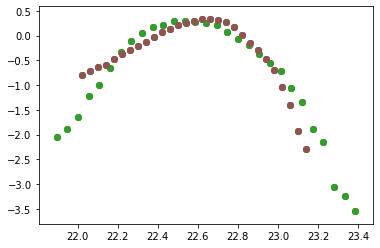

In [14]:
plotting_pdf(data_array_before, 30)
x_arr_before = plotting_pdf(data_array_before, 30)[0]
y_arr_before = plotting_pdf(data_array_before, 30)[1]
plotting_pdf(data_array_after, 30)
x_arr_after = plotting_pdf(data_array_after, 30)[0]
y_arr_after = plotting_pdf(data_array_after, 30)[1]

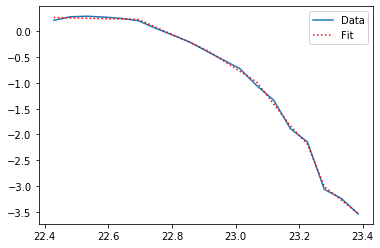

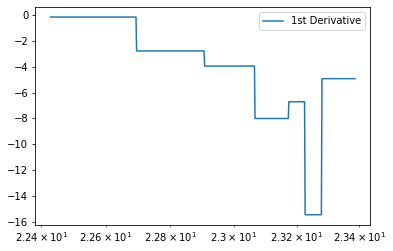

22.69507129174916


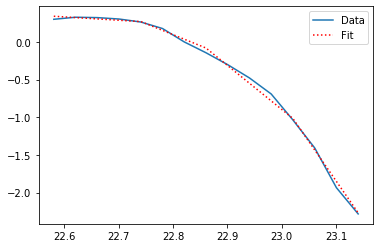

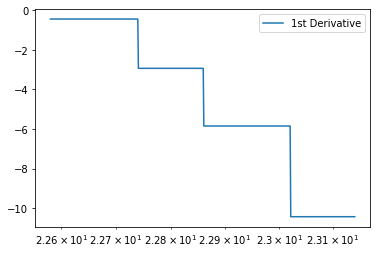

22.74110225414935


In [15]:
x_min_before = spline_method(x_arr_before[10:], y_arr_before[10:-1])[0]
print(x_min_before)

x_min_after = spline_method(x_arr_after[14:], y_arr_after[14:-1])[0]
print(x_min_after)

In [66]:
true_mp = -7
true_b = 135

In [44]:
np.argwhere(x_arr_before >= x_min_before)
y_short = y_arr_before[np.argwhere(x_arr_before >= x_min_before)]
y = y_short.flatten()
x_short = x_arr_before[(np.argwhere(x_arr_before >= x_min_before))]
x = x_short.flatten()

In [49]:
np.argwhere(x_arr_before >= x_min_before)
y_short_before = y_arr_before[np.argwhere(x_arr_before >= x_min_before)]
y_before = y_short_before.flatten()
x_short_before = x_arr_before[(np.argwhere(x_arr_before >= x_min_before))]
x_before = x_short_before.flatten()

In [50]:
np.argwhere(x_arr_after >= x_min_after)
y_short_after = y_arr_after[np.argwhere(x_arr_after >= x_min_after)]
y_after = y_short_after.flatten()
x_short_after = x_arr_after[(np.argwhere(x_arr_after >= x_min_after))]
x_after = x_short_after.flatten()

In [54]:
before_variables = lmfit_func(x_before, y_before)
alpha_before = before_variables[0]
beta_before = before_variables[1]

[[Model]]
    Model(resid_powerlaw)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 13
    # variables        = 2
    chi-square         = 1.05479798
    reduced chi-square = 0.09589073
    Akaike info crit   = -28.6508013
    Bayesian info crit = -27.5209026
[[Variables]]
    mp: -5.94961202 +/- 0.43161236 (7.25%) (init = -6)
    b:   135.844172 +/- 9.95619754 (7.33%) (init = 120)
[[Correlations]] (unreported correlations are < 0.100)
    C(mp, b) = -1.000


In [55]:
after_variables = lmfit_func(x_after, y_after)
alpha_after = after_variables[0]
beta_after = after_variables[1]

[[Model]]
    Model(resid_powerlaw)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 10
    # variables        = 2
    chi-square         = 0.32116590
    reduced chi-square = 0.04014574
    Akaike info crit   = -30.3838257
    Bayesian info crit = -29.7786555
[[Variables]]
    mp: -6.73323469 +/- 0.55108296 (8.18%) (init = -6)
    b:   153.790765 +/- 12.6534540 (8.23%) (init = 120)
[[Correlations]] (unreported correlations are < 0.100)
    C(mp, b) = -1.000


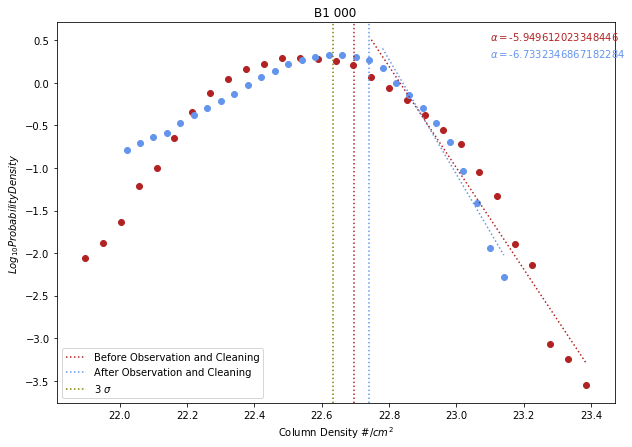

In [65]:
final_plot(x_arr_before, y_arr_before, x_min_before, alpha_before, beta_before, x_arr_after, y_arr_after, x_min_after, alpha_after, beta_after)